<a href="https://colab.research.google.com/github/sborah53/Machine-Learning-for-Physical-Sciences/blob/main/MLPS_Polynomial_Regression_Physics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Polynomial Regression

**Notebook created by: Sangkha Borah, IIT Hyderabad**


We model the potential energy of a diatomic molecule as a function of internuclear separation $r$ using the Morse potential
$$
V(r) = D_e \left(1 - e^{-a (r - r_e)}\right)^2,
$$
where $D_e$ is the well depth, $a$ controls the width, and $r_e$ is the equilibrium bond length.

To avoid fitting the Morse form directly, we approximate $V(r)$ by a polynomial of degree $d$,
$$
V(r) \approx w_0 + w_1 r + w_2 r^2 + \dots + w_d r^d,
$$
and determine the coefficients from noisy samples $\{(r_i, V_i)\}$ using least squares. Defining the design (Vandermonde) matrix $\Phi$ with elements
$$
\Phi_{ij} = r_i^{\,j}, \qquad j = 0,\dots,d,
$$
the model is written as
$$
\mathbf{V} \approx \Phi \mathbf{w},
$$
and the optimal parameters satisfy the normal equations
$$
\Phi^{\mathsf{T}} \Phi \,\mathbf{w} = \Phi^{\mathsf{T}} \mathbf{V},
$$
which we solve as
$$
\mathbf{w} = \left(\Phi^{\mathsf{T}} \Phi\right)^{-1} \Phi^{\mathsf{T}} \mathbf{V}
$$
or numerically via the Moore–Penrose pseudoinverse.

In the notebook we implement this polynomial regression twice: first from scratch by constructing $\Phi$ and solving the normal equations, and then using `PolynomialFeatures` and `LinearRegression` from scikit-learn, which should yield identical coefficients up to numerical precision.


In [4]:
#@title  Imports, physics, data

import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error

# ==========================================
# 1. Physics Simulation: Diatomic Potential
# ==========================================
def morse_potential(r, De, a, re):
    return De * (1 - np.exp(-a * (r - re)))**2

# True parameters
De_true = 4.75  # eV
a_true  = 1.94  # Ang^-1
re_true = 0.74  # Ang

# Synthetic data
np.random.seed(42)
r_data = np.linspace(0.4, 1.4, 30)
noise_level = 0.1
V_true = morse_potential(r_data, De_true, a_true, re_true)
V_data = V_true + np.random.normal(0, noise_level, size=r_data.shape)

# Common X, y, degree
X = r_data.reshape(-1, 1)
y = V_data
degree = 4


--- Custom Model (Scratch) ---
True Equilibrium (re):        0.7400 A
Fitted Equilibrium (re):      0.7504 A
Theoretical Force Constant k: 35.7542 eV/A^2
Fitted Force Constant k:      38.9192 eV/A^2
Custom Model RMSE:            0.078362
Weights (Custom):             [  31.70515121 -120.95492263  164.64164354  -95.05091252   20.36095155]


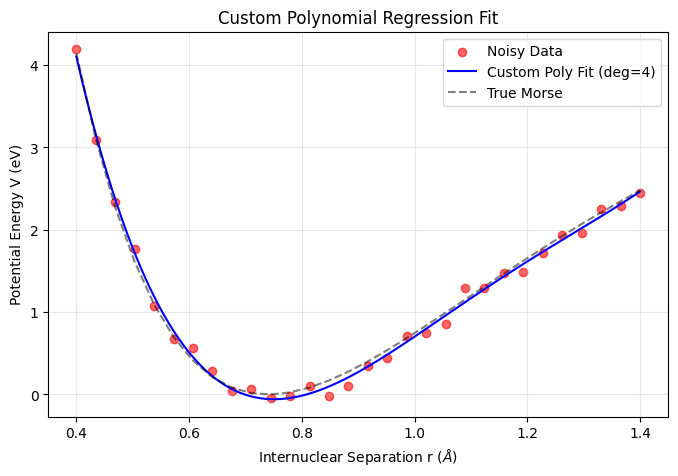

In [5]:
#@title Custom Implementation

# ==========================================
# 2. Polynomial Regression from Scratch
# ==========================================
class PolynomialRegressionScratch:
    def __init__(self, degree):
        self.degree = degree
        self.weights = None

    def _create_design_matrix(self, X):
        n_samples = X.shape[0]
        phi = np.ones((n_samples, 1))
        for d in range(1, self.degree + 1):
            phi = np.hstack((phi, X**d))
        return phi

    def fit(self, X, y):
        Phi = self._create_design_matrix(X)
        phi_T = Phi.T
        self.weights = np.linalg.pinv(phi_T @ Phi) @ phi_T @ y

    def predict(self, X):
        Phi = self._create_design_matrix(X)
        return Phi @ self.weights

# --- Train custom model ---
model_custom = PolynomialRegressionScratch(degree=degree)
model_custom.fit(X, y)
y_pred_custom = model_custom.predict(X)

# --- Physics analysis from custom model ---
r_fine = np.linspace(0.4, 1.4, 1000).reshape(-1, 1)
V_fine_custom = model_custom.predict(r_fine)

min_idx = np.argmin(V_fine_custom)
r_eq_fit_custom = r_fine[min_idx][0]
V_eq_fit_custom = V_fine_custom[min_idx]

w = model_custom.weights
k_fit_custom = 2*w[2] + 6*w[3]*r_eq_fit_custom + 12*w[4]*(r_eq_fit_custom**2)
k_theory = 2 * De_true * a_true**2

print("--- Custom Model (Scratch) ---")
print(f"True Equilibrium (re):        {re_true:.4f} A")
print(f"Fitted Equilibrium (re):      {r_eq_fit_custom:.4f} A")
print(f"Theoretical Force Constant k: {k_theory:.4f} eV/A^2")
print(f"Fitted Force Constant k:      {k_fit_custom:.4f} eV/A^2")
print(f"Custom Model RMSE:            {np.sqrt(mean_squared_error(y, y_pred_custom)):.6f}")
print(f"Weights (Custom):             {w}")

# Optional: plot custom vs Morse
plt.figure(figsize=(8, 5))
plt.scatter(r_data, V_data, color='red', label='Noisy Data', alpha=0.6)
plt.plot(r_fine, V_fine_custom, color='blue', label=f'Custom Poly Fit (deg={degree})')
plt.plot(r_data, V_true, 'k--', label='True Morse', alpha=0.5)
plt.xlabel(r'Internuclear Separation r ($\AA$)')
plt.ylabel('Potential Energy V (eV)')
plt.title('Custom Polynomial Regression Fit')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


--- Scikit-Learn Model ---
Sklearn Model RMSE:           0.078362
Weights (Sklearn):            [  31.70515122 -120.95492264  164.64164355  -95.05091253   20.36095155]


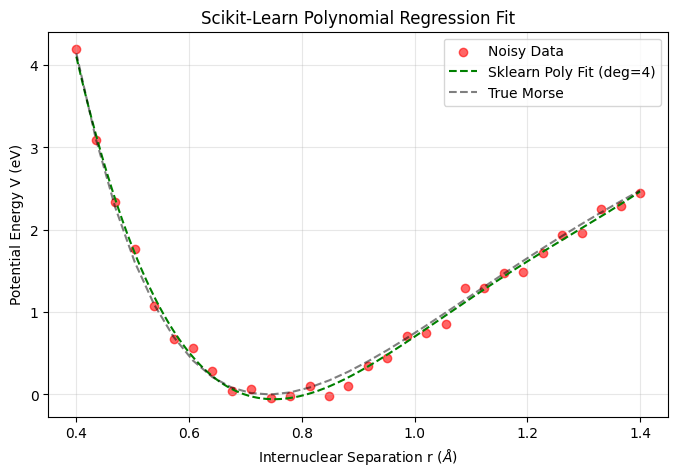

In [6]:
#@title Scikit-learn

# ==========================================
# 3. Polynomial Regression with Scikit-Learn
# ==========================================
poly_features = PolynomialFeatures(degree=degree, include_bias=True)
X_poly = poly_features.fit_transform(X)

model_sklearn = LinearRegression(fit_intercept=False)
model_sklearn.fit(X_poly, y)
y_pred_sklearn = model_sklearn.predict(X_poly)

# Fine grid for plotting
X_fine_poly = poly_features.transform(r_fine)
V_fine_sklearn = model_sklearn.predict(X_fine_poly)

print("--- Scikit-Learn Model ---")
print(f"Sklearn Model RMSE:           {np.sqrt(mean_squared_error(y, y_pred_sklearn)):.6f}")
print(f"Weights (Sklearn):            {model_sklearn.coef_}")

# Optional: plot sklearn vs Morse
plt.figure(figsize=(8, 5))
plt.scatter(r_data, V_data, color='red', label='Noisy Data', alpha=0.6)
plt.plot(r_fine, V_fine_sklearn, color='green', linestyle='--',
         label=f'Sklearn Poly Fit (deg={degree})')
plt.plot(r_data, V_true, 'k--', label='True Morse', alpha=0.5)
plt.xlabel(r'Internuclear Separation r ($\AA$)')
plt.ylabel('Potential Energy V (eV)')
plt.title('Scikit-Learn Polynomial Regression Fit')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()
